In [1]:
import sys
import os
import psycopg2
import pandas as pd
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from nltk.corpus import stopwords
import unicodedata
import string
import numpy as np
import spacy    
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [2]:
def retrieve_reviews(product):
    conn = psycopg2.connect(dbname='product_reviews', user='postgres', password='', host='localhost')
    cursor = conn.cursor()
    p_no = 0
    r_no = 0
    cursor.execute("select * from reviews where r_comments like 'Verified%' and product_name = '{}'".format(product))
    rows = cursor.fetchall()
    df = pd.DataFrame(rows)
    cursor.close()
    conn.close()
    return df

def retrieve_all_reviews():
    conn = psycopg2.connect(dbname='product_reviews', user='postgres', password='', host='localhost')
    cursor = conn.cursor()
    p_no = 0
    r_no = 0
    cursor.execute("select * from reviews where r_comments like 'Verified%' ")
    rows = cursor.fetchall()
    df = pd.DataFrame(rows)
    cursor.close()
    conn.close()
    return df



In [3]:
#df = retrieve_reviews('LG Electronics 65UJ6300 65-Inch 4K Ultra HD Smart LED TV (2017 Model)')
df = retrieve_all_reviews()

In [4]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,10
0,1,LG Electronics 65UJ6300 65-Inch 4K Ultra HD Sm...,https://www.amazon.com/LG-Electronics-65UJ6300...,1,1,5.0 out of 5 stars,"September 22, 2017",Prime Customer,"TV Great, TruMotion Bad!",Now that I found the TruMotion setting so that...,Verified Purchase Helpful No...
1,2,LG Electronics 65UJ6300 65-Inch 4K Ultra HD Sm...,https://www.amazon.com/LG-Electronics-65UJ6300...,1,2,5.0 out of 5 stars,"December 30, 2017",GMC,Hint: Turn OFF Smart Picture Mode,Hint: Turn off Smart Picture Mode and then tur...,Verified Purchase Helpful No...


In [5]:
columns = ['id','p_name','url','p_no','r_no','r_stars','r_date','r_name','r_title','r_text','r_comments']
df.columns = columns
df.groupby(['r_stars']).count()
df_new = df.copy()
df_new = df_new[df_new['r_stars'].apply(lambda x: x in ['5.0 out of 5 stars','1.0 out of 5 stars'])]
df_new['rating'] = df_new['r_stars'].apply(lambda x: 1 if x == '5.0 out of 5 stars' else 0)
df_new = df_new[['rating','r_name','r_text']]
df_new.head(3)

,rating,r_name,r_text
0,1,Prime Customer,Now that I found the TruMotion setting so that...
1,1,GMC,Hint: Turn off Smart Picture Mode and then tur...
2,1,AncientGhost,Needed an upgrade for my 7yr old HDTV and deci...


In [6]:
nlp = spacy.load("en")
document = df_new.iloc[3]['r_text']
parsed_document = nlp(document)

for num, sentence in enumerate(parsed_document.sents):
    print (num, sentence)

0 Came in perfect condition.
1 Decent sized tv.
2 Good picture (after adjusting picture and energy settings).
3 Very easy to setup.
4 Unless your tv came damaged, I dont know what anyone could be complaining about?


In [7]:
for num, entity in enumerate(parsed_document.ents):
    print (entity, entity.label_)
token_text = [token.orth_ for token in parsed_document]
token_pos = [token.pos_ for token in parsed_document]
token_tag = [token.tag_ for token in parsed_document]

token_lemma = [token.lemma_ for token in parsed_document]
token_shape = [token.shape_ for token in parsed_document]
token_prob = [token.prob for token in parsed_document]

In [8]:
df_spicy = pd.DataFrame({'token_text':token_text, 'token_lemma':token_lemma, 'token_pos':token_pos,'token_prob':token_prob, 'token_tag':token_tag})

df_spicy

,token_lemma,token_pos,token_prob,token_tag,token_text
0,come,VERB,-11.294542,VB,Came
1,in,ADP,-4.619072,IN,in
2,perfect,ADJ,-9.035118,JJ,perfect
3,condition,NOUN,-10.460976,NN,condition
4,.,PUNCT,-3.067898,.,.
5,decent,ADJ,-13.081412,JJ,Decent
6,sized,ADJ,-10.837564,JJ,sized
7,tv,NOUN,-10.503740,NN,tv
8,.,PUNCT,-3.067898,.,.
9,good,ADJ,-8.468017,JJ,Good


In [9]:
stop_words = set(stopwords.words('english'))

def punct_space(token):
    return token.is_punct or token.is_space

def is_stop_word(token):
    return token in stop_words

def is_noun(token):
    return token.pos_ in ['NOUN','ADJ','PROPN',"VERB"]
    #return token.pos_ in ["ADJ",'NOUN']

def keep(token):
    return is_noun(token) and is_stop_word(token) == False and punct_space(token) == False


def lemmatized_sentence_corpus (documents):
    for doc in documents:
        parsed_doc = nlp(doc)
        for sent in parsed_doc.sents:
            yield (' '.join([token.lemma_ for token in sent if keep(token)]))


In [10]:
bigram_model = Phrases([doc.split(" ") for doc in lemmatized_sentence_corpus(df_new['r_text'].values)], min_count=2)
bigram_sentences = []
for unigram_sentence in lemmatized_sentence_corpus(df_new['r_text'].values):
    bigram_sentences.append(' '.join(bigram_model[unigram_sentence.split(" ")]))
trigram_model = Phrases([doc.split(" ") for doc in bigram_sentences], min_count=2)
#trigram_model.vocab

In [73]:
# from gensim.models import Phrases
# documents = ["the mayor of york mayor was there", "machine learning can be useful sometimes","new york mayor was present"]

# sentence_stream = [doc.split(" ") for doc in documents]
# print (sentence_stream)
# bigram = Phrases(sentence_stream, min_count=1, threshold=1)
# sent = [u'the', u'of', u'new', u'york',  u'mayor', u'was', u'there']
# print(bigram[sent])

In [11]:
bigram_sentences[0]

trigram_sentences = []
for bigram_sentence in bigram_sentences:
    trigram_sentences.append(' '.join(trigram_model[bigram_sentence.split(" ")]))

trigram_sentences[10]

'go my_old tv one be like night day'

In [75]:
# trigram_reviews = LineSentence(trigram_sentences)
# trigram_dictionary = Dictionary([doc.split(" ") for doc in trigram_sentences])
# trigram_dictionary.filter_extremes(no_below=5, no_above=0.4)
# def trigram_bow_generator(trigram_sentences):
#     trigram_bow = []
#     for review in trigram_sentences:
#         print (review)
#         trigram_bow.append(trigram_dictionary.doc2bow(review))

In [76]:
#trigram_bow = trigram_bow_generator([doc.split(" ") for doc in trigram_sentences])

In [12]:
corpus = []
terms_doc = []
count = 0
for doc in df_new['r_text'].values:
    parsed_doc = nlp(doc)
    bigram_doc = ' '.join(bigram_model[(token.lemma_ for token in parsed_doc if keep(token))])
    trigram_doc = ' '.join(trigram_model[(token for token in bigram_doc.split(" "))])    
    corpus.append (trigram_doc)
    terms_doc.append(trigram_model[(token for token in bigram_doc.split(" "))])

In [13]:
data = corpus

In [14]:
data[1]

'hint turn smart picture mode turn energy_saver off. smart picture mode access energy_saver setting picture be dull drab energy_saver reduce backlight save energy cost poor picture_quality make change tv picture be bright_sharp great detail'

In [17]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 2
 
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(corpus)

print (type(data_vectorized),data_vectorized.shape)

# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=NUM_TOPICS)
nmf_Z = nmf_model.fit_transform(data_vectorized)
print(nmf_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized)
print(lsi_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
 
# Let's see how the first document in the corpus looks like in different topic spaces
print(lda_Z[0])
print(nmf_Z[0])
print(lsi_Z[0])

<class 'scipy.sparse.csr.csr_matrix'> (2835, 1120)
(2835, 2)
(2835, 2)
(2835, 2)
[0.32884924 0.67115076]
[0.23186088 0.02161067]
[ 1.90663673 -0.82262696]


In [81]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(lda_model, vectorizer)
print("=" * 20)
 
print("NMF Model:")
print_topics(nmf_model, vectorizer)
print("=" * 20)
 
print("LSI Model:")
print_topics(lsi_model, vectorizer)
print("=" * 20)

LDA Model:
Topic 0:
[('picture', 1180.199120005394), ('great', 1040.269680637114), ('love', 577.7769104490297), ('good', 467.9632501514887), ('sound', 458.95477708094916), ('quality', 448.1550644708251), ('use', 384.2512664663249), ('easy', 377.52549951571297), ('remote', 373.5333179861955), ('set', 361.18452435987655)]
Topic 1:
[('samsung', 620.3568196088231), ('work', 492.40989292766363), ('screen', 335.10166251157744), ('buy', 299.78183620172894), ('time', 255.3503542864891), ('box', 233.88332432376586), ('amazon', 209.63808082783262), ('product', 200.8909523962694), ('problem', 195.45409036449823), ('new', 186.63150358491498)]
NMF Model:
Topic 0:
[('picture', 4.473203408903392), ('great', 3.0954402896428657), ('sound', 2.1618785068054924), ('quality', 1.8256624100918504), ('look', 1.7310659402018465), ('set', 1.6799649842501663), ('use', 1.6478037327554835), ('good', 1.3896672811410973), ('remote', 1.3581272718631028), ('cable', 1.219347299208343)]
Topic 1:
[('samsung', 4.729042652

In [82]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

Loading BokehJS ...

In [83]:
svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(corpus))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

In [84]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 3
 
vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(corpus)
 
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)
 
text = "The economy is working better than ever"
x = lda_model.transform(vectorizer.transform([text]))[0]
print(x, x.sum())

[0.1886132  0.62095599 0.19043081] 1.0


In [85]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'lda.html')
#pyLDAvis.enabled_notebook()
pyLDAvis.display(panel)

In [86]:
from gensim.models import Word2Vec

In [87]:
model = Word2Vec(terms_doc, size=100, window=5, min_count=5, workers=4)

In [88]:
model.wv.most_similar(positive=['great'])
#model.wv.index2word

[('sound', 0.9997225999832153),
 ('picture', 0.9997178316116333),
 ('good', 0.9997177124023438),
 ('amazing', 0.9997039437294006),
 ('excellent', 0.9996931552886963),
 ('awesome', 0.9996300339698792),
 ('price', 0.9995906949043274),
 ('easy_set', 0.9995689988136292),
 ('picture_quality', 0.9995604753494263),
 ('love', 0.9995560646057129)]

In [89]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
import warnings
warnings.filterwarnings("ignore")

In [90]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

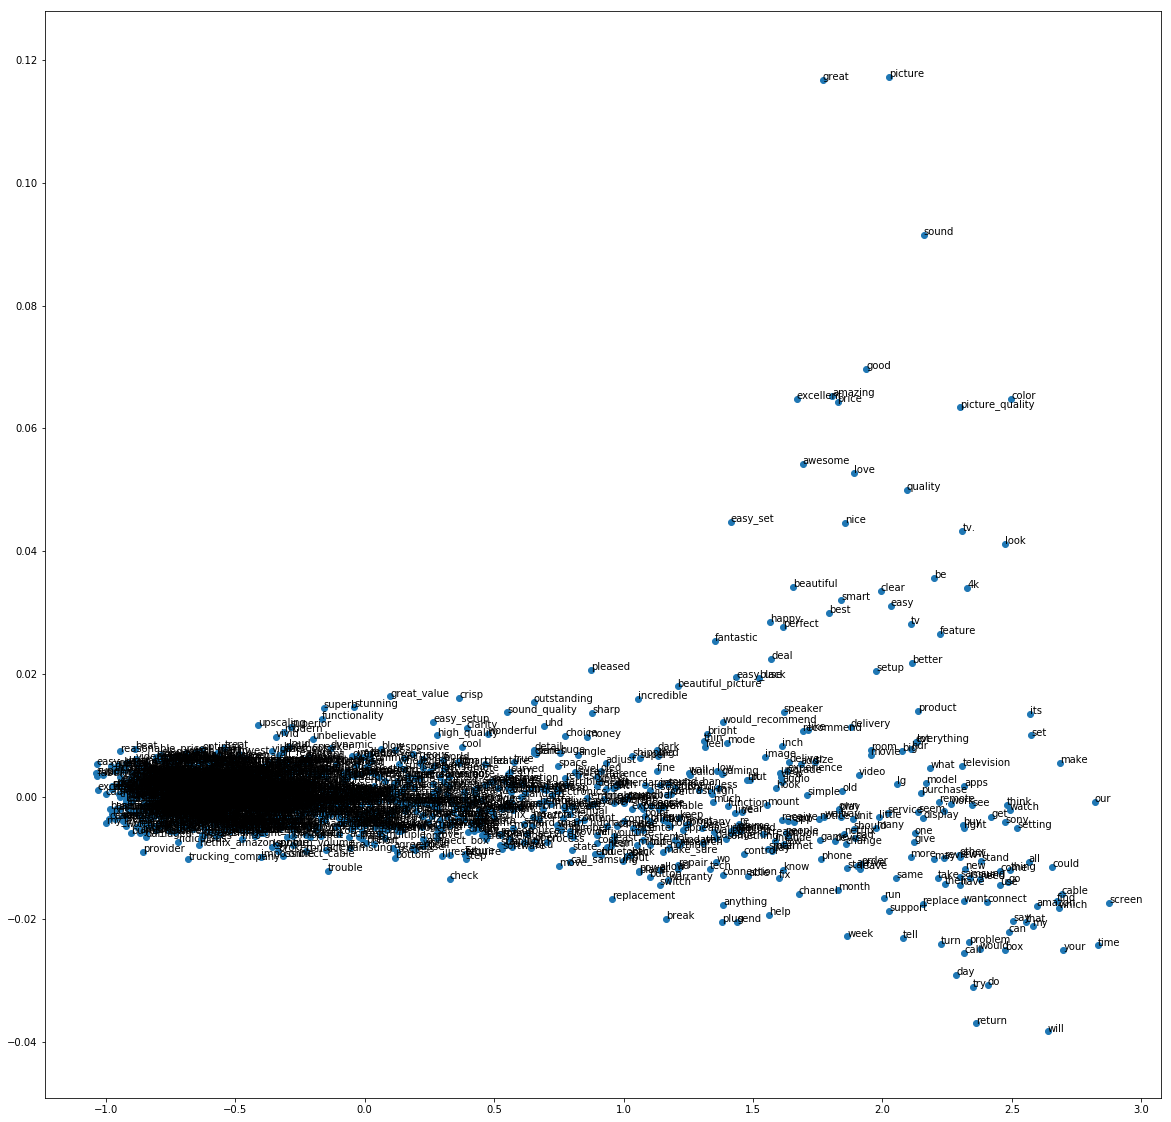

In [91]:

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

fig,ax = plt.subplots(figsize=(20,20))
ax.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    ax.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [92]:
def visualize(model, output_path):
    meta_file = "w2x_metadata.tsv"
    placeholder = np.zeros((len(model.wv.index2word), 100))

    with open(os.path.join(output_path,meta_file), 'wb') as file_metadata:
        for i, word in enumerate(model.wv.index2word):
            placeholder[i] = model[word]
            # temporary solution for https://github.com/tensorflow/tensorflow/issues/9094
            if word == '':
                print("Emply Line, should replecaed by any thing else, or will cause a bug of tensorboard")
                file_metadata.write("{0}".format('<Empty Line>').encode('utf-8') + b'\n')
            else:
                file_metadata.write("{0}".format(word).encode('utf-8') + b'\n')

    # define the model without training
    sess = tf.InteractiveSession()

    embedding = tf.Variable(placeholder, trainable = False, name = 'w2x_metadata')
    tf.global_variables_initializer().run()

    saver = tf.train.Saver()
    writer = tf.summary.FileWriter(output_path, sess.graph)

    # adding into projector
    config = projector.ProjectorConfig()
    embed = config.embeddings.add()
    embed.tensor_name = 'w2x_metadata'
    embed.metadata_path = meta_file

    # Specify the width and height of a single thumbnail.
    projector.visualize_embeddings(writer, config)
    saver.save(sess, os.path.join(output_path,'w2x_metadata.ckpt'))
    print('Run `tensorboard --logdir={0}` to run visualize result on tensorboard'.format(output_path))


In [93]:
visualize(model.wv, 'data/tensor/')

Run `tensorboard --logdir=data/tensor/` to run visualize result on tensorboard
